# Getting Started: Market Research
This Jupyter notebook is a quick demonstration on how to get started on the market research section.

## 1) Download Data
Please download the train and test data and place it within the ./research/data path. If you've placed it in the correct place, you should see the following cell work:

In [ ]:
import pandas as pd

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
# train_new = pd.read_csv("data/train_new.csv")
# test_new = pd.read_csv("data/test_new.csv")

def reduce_mem_usage(df, float16_as_32=True, category_threshold=0.5, verbose=True):
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    # Process each column
    for col in df.columns:
        col_type = df[col].dtype

        # Handle numeric columns
        if np.issubdtype(col_type, np.number):
            col_min = df[col].min()
            col_max = df[col].max()

            # Integer types
            if np.issubdtype(col_type, np.integer):
                if col_min >= 0:  # Unsigned integers
                    if col_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:  # Signed integers
                    if (
                        col_min > np.iinfo(np.int8).min
                        and col_max < np.iinfo(np.int8).max
                    ):
                        df[col] = df[col].astype(np.int8)
                    elif (
                        col_min > np.iinfo(np.int16).min
                        and col_max < np.iinfo(np.int16).max
                    ):
                        df[col] = df[col].astype(np.int16)
                    elif (
                        col_min > np.iinfo(np.int32).min
                        and col_max < np.iinfo(np.int32).max
                    ):
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)

            # Floating point types
            else:
                if (
                    col_min > np.finfo(np.float16).min
                    and col_max < np.finfo(np.float16).max
                ):
                    if float16_as_32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)
                elif (
                    col_min > np.finfo(np.float32).min
                    and col_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        # Handle object/string columns
        elif  isinstance(col_type,object) or col_type.name == "string":
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])

            # Convert to category if threshold is met
            if num_unique_values / num_total_values < category_threshold:
                df[col] = df[col].astype("category")

        elif np.issubdtype(col_type, np.datetime64):
            # Downcast datetime to smallest possible unit
            if df[col].dt.nanosecond.max() == 0:
                if df[col].dt.microsecond.max() == 0:
                    if df[col].dt.second.max() == 0:
                        if df[col].dt.minute.max() == 0:
                            if df[col].dt.hour.max() == 0:
                                df[col] = df[col].astype("datetime32[D]")
                            else:
                                df[col] = df[col].astype("datetime32[h]")
                        else:
                            df[col] = df[col].astype("datetime32[m]")
                    else:
                        df[col] = df[col].astype("datetime32[s]")
                else:
                    df[col] = df[col].astype("datetime32[ms]")
            else:
                df[col] = df[col].astype("datetime64[ns]")
    if verbose:
        end_mem = df.memory_usage(deep=True).sum() / 1024**2
        reduction = 100 * (start_mem - end_mem) / start_mem
        print(f"Memory usage before: {start_mem:.2f} MB")
        print(f"Memory usage after: {end_mem:.2f} MB")
        print(f"Reduced by {reduction:.1f}%")

    return df


# train_data = reduce_mem_usage(train_data)
# train_data = reduce_mem_usage(test_data)
# train_data.set_index("time", inplace=True)
# test_data.set_index("time", inplace=True)

## 2) Investigate the Dataset
In the datasets, you're given columns of time and A through N, each of which represent some sort of real-life market quantity. In the train dataset, you're also given Y1 and Y2, real-life market quantities you'd like to predict in terms of time and A through N. You're not given Y1 and Y2 in the test set, because this is what you're being asked to predict.

Let's do some exploration of the relationships of A - N and Y1. In particular, let's look at the relationship between C and Y1:

In [50]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.scatter(train_data['C'], train_data['Y1'])
# plt.xlabel('C')
# plt.ylabel('Y1')
# plt.title('Relationship between C and Y1')
# plt.show()

In [51]:
import seaborn as sns

# corr = train_data.corr()
# plt.figure(figsize=(10,8))
# sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm", square=True)
# plt.title("stock correlation heatmap")
# plt.tight_layout()
# plt.show()


In [52]:
import numpy as np



target = ["Y1", "Y2"]


def create_financial_features(df):
    new_features_list = []
    for feature in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']:
        new_features_list.append(df[feature].shift(1).rename(f"{feature}_lag1"))
        new_features_list.append(df[feature].shift(2).rename(f"{feature}_lag2"))
        new_features_list.append(df[feature].shift(3).rename(f"{feature}_lag3"))
        
        new_features_list.append((df[feature] / df[feature].shift(5) - 1).rename(f"{feature}_roc5"))
        new_features_list.append((df[feature] / df[feature].shift(10) - 1).rename(f"{feature}_roc10"))
        
        rolling_min = df[feature].rolling(window=10).min()
        rolling_max = df[feature].rolling(window=10).max()
        hl_range = rolling_max - rolling_min
        
        regime = (df[feature] - rolling_min) / np.where(hl_range == 0, 1e-6, hl_range)
        new_features_list.append(regime.rename(f"{feature}_regime"))
        
        regime_strength = np.abs(regime - 0.5) * 2
        new_features_list.append(regime_strength.rename(f"{feature}_regime_strength"))
        
        ema_short = df[feature].ewm(span=5, adjust=False).mean()
        ema_long = df[feature].ewm(span=10, adjust=False).mean()
        
        macd = ema_short - ema_long
        new_features_list.append(macd.rename(f"{feature}_macd"))
        
        macd_signal = macd.ewm(span=3, adjust=False).mean()
        new_features_list.append(macd_signal.rename(f"{feature}_macd_signal"))
        
        macd_hist = macd - macd_signal
        new_features_list.append(macd_hist.rename(f"{feature}_macd_hist"))
        
    new_features_df = pd.concat(new_features_list, axis=1)
    
    return pd.concat([df, new_features_df], axis=1)


# train_data = create_financial_features(train_data)
# test_data = create_financial_features(test_data)
# train_data = pd.concat([train_data,train_new],axis=1)
# test_data = pd.concat([test_data,test_new],axis=1)


features = [col for col in train_data.columns if col not in target]

print(f"{target = }")
print(f"{features = }")


X = train_data[features]
Y = train_data[target]
# corr2 = train_data[features + target].corr()[target]
# sns.heatmap(corr2, annot=True, fmt='.2f', cmap="coolwarm")
# plt.title("corr 2")
# plt.show()



target = ['Y1', 'Y2']
features = ['time', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']


In [53]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# from sklearn.model_selection import TimeSeriesSplit





# print("Y2 skewness:", Y['Y2'].skew())
# print("Y2 kurtosis:", Y['Y2'].kurtosis())
# sns.histplot(Y['Y2'], kde=True)
# plt.title("Distribution of Y2 (Target)")
# plt.show()

# transformed_Y2 = np.arcsinh(Y["Y2"])

# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# sns.histplot(transformed_Y2,kde=True)
# plt.show()



# tscv = TimeSeriesSplit(n_splits=3)

# for train_idx,test_idx in tscv.split(X):
#     print(Y.iloc[test_idx])
# vif = pd.DataFrame()
# vif["Feature"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

# print(vif)

# # not multicolinear, so don't need to rm columns

In [54]:
# from sklearn.feature_selection import mutual_info_regression

# m1 = mutual_info_regression(X,train_data["Y1"])
# m2 = mutual_info_regression(X,test_data["Y2"])



# pd.DataFrame({"M1_Y1" : m1, "M2" : m2}, index=X.columns)

In [55]:
# from statsmodels.tsa.stattools import adfuller

# Y1 = adfuller(test_data["Y1"])
# Y2 = adfuller(train_data["Y2"])

# print(Y1,Y2)

In [56]:
# C E G H J M N highly correlated to Y1
# A B D F I K L highly correlated to Y2

In [57]:
from typing import Any, Dict
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import QuantileTransformer, StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor

Y1_FEATURES = ['C', 'E', 'G', 'H', 'J', 'M', 'N','time']
Y2_FEATURES = ['A', 'B', 'D', 'F', 'I', 'K', 'L','time']


def custom_metric(y_true,y_pred):
    if hasattr(y_true,"values"):
        y_true = y_true.values
    if hasattr(y_pred,"values"):
        y_pred = y_pred.values
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    r2_y1 = r2_score(y_true[:,0],y_pred[:,0])
    r2_y2 = r2_score(y_true[:,1],y_pred[:,1])
    print(f"{r2_y1 = }")
    print(f"{r2_y2 = }")
    
    return (r2_y1 + r2_y2 ) / 2

In [58]:
import xgboost as xgb
def tune_model_y2(X,Y,n_trials=30,n_splits=3) -> Dict[str, Any]:
    X_arr = X.values if hasattr(X, 'values') else X
    Y_arr = Y.values if hasattr(Y, 'values') else Y
    Y_arr = Y_arr.ravel()

    
    def objective(trial: optuna.Trial) -> float:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 12),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),
            "colsample_bytree" : trial.suggest_float("colsample_bytree",0.5,1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            "reg_lambda" : trial.suggest_float("reg_lambda", 0.0, 10.0),
            "gamma" : trial.suggest_float("gamma",0.0,5.0),
            "eval_metric" : "rmse",
            "verbosity" : 0,
            'random_state': 42,
            "early_stopping_rounds" : 50
        }
        
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        res = []
        for train_idx, test_idx in tscv.split(X_arr):
            
            X_train,X_val = X_arr[train_idx].copy(), X_arr[test_idx].copy()
            y_train,y_val = Y_arr[train_idx].copy(), Y_arr[test_idx].copy()
        
            
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model =   xgb.XGBRegressor(**params).fit(
                X_train_scaled,
                y_train,
                eval_set=[(X_val,y_val)],
                verbose=False,
                )
            
            
            y_pred = model.predict(X_val_scaled)
            r2 = r2_score(
                y_pred=y_pred,
                y_true=y_val,
            )
            
            res.append(r2)
            
        return np.mean(res)
            
        
        
    study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(
            n_startup_trials=10,
            n_warmup_steps=5,
            interval_steps=1
        )
        )
    study.optimize(
        objective,
        n_trials=n_trials,
        gc_after_trial=True,
        show_progress_bar=True,
        n_jobs=1,
    )
    
    return study.best_params

In [59]:
from sklearn.linear_model import LinearRegression, ElasticNet


def tune_model_y1(X,Y,n_trials=30,n_splits=3) -> Dict[str, Any]:
    X_arr = X.values if hasattr(X, 'values') else X
    Y_arr = Y.values if hasattr(Y, 'values') else Y
    
    def objective(trial: optuna.Trial) -> float:
        params = {
            "epsilon" : trial.suggest_float("epsilon", 1,10),
            "alpha" : trial.suggest_float("alpha",1e-5,30, log=True),
            "max_iter" : 1000,
        }
     
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        res = []
        for train_idx, test_idx in tscv.split(X_arr):
            
            X_train,X_val = X_arr[train_idx].copy(), X_arr[test_idx].copy()
            y_train,y_val = Y_arr[train_idx].copy(), Y_arr[test_idx].copy()
            
            
            #scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model = HuberRegressor(**params).fit(X_train_scaled,y_train)

            res.append(r2_score(y_pred=model.predict(X_val_scaled),y_true=y_val))

        
        return np.mean(res)
            
        
        
    study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(
            n_startup_trials=10,
            n_warmup_steps=5,
            interval_steps=1,
        )
        )
    study.optimize(
        objective,
        n_trials=n_trials,
        gc_after_trial=True,
        show_progress_bar=True,
        n_jobs=1,
    )
    
    return study.best_params

In [60]:
def tune_separated_model(X,Y,n_trials=30,n_splits=3):

    
    y1_params = tune_model_y1(
                                X[Y1_FEATURES],
                                Y["Y1"],
                                n_trials=n_trials,
                                n_splits=n_splits
                                )
    y2_params = tune_model_y2(
                                X[Y2_FEATURES],
                                Y[['Y2']],
                                n_trials=n_trials,
                                n_splits=n_splits
                            )
    
    return {
        "Y1" : y1_params,
        "Y2" : y2_params
    }

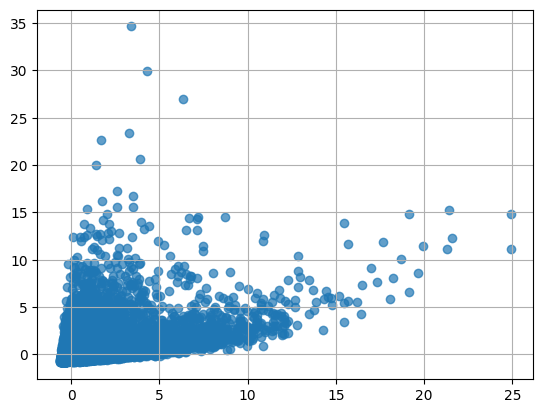

In [61]:
visual_data = train_data[["A"]]
plt.scatter(visual_data,train_data["Y2"],alpha=0.7)
plt.grid(True)
plt.show()

In [62]:
n: int = len(train_data)
split_idx = int(0.8 * n)
X_train,X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

best_params = tune_separated_model(X_train,y_train,n_trials=50,n_splits=3)
# best_params = {
#     "Y1" : {'epsilon': 3.2945411727994856, 'alpha': 0.1907403892569902},
#     "Y2" : {'n_estimators': 310, 'learning_rate': 0.02409495444205328, 'max_depth': 11, 'subsample': 0.5585740150829815, 'colsample_bytree': 0.8466743730518109, 'min_child_weight': 3, 'reg_alpha': 9.224057532893077, 'reg_lambda': 2.715322419185381, 'gamma': 0.3094132988630924}
# }

scaler_y1 = StandardScaler()
X_train_y1 = scaler_y1.fit_transform(X_train[Y1_FEATURES])
model_y1 = HuberRegressor(**best_params["Y1"]).fit(X_train_y1,y_train["Y1"])


scaler_y2 = StandardScaler()
X_train_y2 = scaler_y2.fit_transform(X_train[Y2_FEATURES])
model_y2 = xgb.XGBRegressor(**best_params["Y2"]).fit(X_train_y2,y_train["Y2"])


y1_pred = model_y1.predict(scaler_y1.transform(X_test[Y1_FEATURES]))
y2_pred = model_y2.predict(scaler_y2.transform(X_test[Y2_FEATURES]))

preds = pd.DataFrame({'Y1': y1_pred, 'Y2': y2_pred}, index=X_test.index)




[I 2025-09-27 11:37:53,067] A new study created in memory with name: no-name-0ee5af70-31dc-4018-a9ba-b6c0473c750b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 11:37:54,138] Trial 0 finished with value: 0.7623993112638828 and parameters: {'epsilon': 4.370861069626263, 'alpha': 14.384402975546456}. Best is trial 0 with value: 0.7623993112638828.
[I 2025-09-27 11:37:55,179] Trial 1 finished with value: 0.7619545019986008 and parameters: {'epsilon': 7.587945476302646, 'alpha': 0.07543685815388836}. Best is trial 0 with value: 0.7623993112638828.
[I 2025-09-27 11:37:56,534] Trial 2 finished with value: 0.762397435441415 and parameters: {'epsilon': 2.4041677639819286, 'alpha': 0.00010242251205083784}. Best is trial 0 with value: 0.7623993112638828.
[I 2025-09-27 11:37:57,759] Trial 3 finished with value: 0.7621482482990768 and parameters: {'epsilon': 1.5227525095137953, 'alpha': 4.076879958997543}. Best is trial 0 with value: 0.7623993112638828.
[I 2025-09-27 11:37:58,819] Trial 4 finished with value: 0.7621002332173461 and parameters: {'epsilon': 6.41003510568888, 'alpha': 0.3857198094357032}. Best is trial 0 with value: 0.762399311

[I 2025-09-27 11:38:47,298] A new study created in memory with name: no-name-2c98906d-cbd1-4d49-b1b2-298955ecab03


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 11:38:48,800] Trial 0 finished with value: 0.6307149665075645 and parameters: {'n_estimators': 212, 'learning_rate': 0.08927180304353628, 'max_depth': 10, 'subsample': 0.7394633936788146, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352, 'gamma': 3.005575058716044}. Best is trial 0 with value: 0.6307149665075645.
[I 2025-09-27 11:38:50,944] Trial 1 finished with value: 0.640357421198597 and parameters: {'n_estimators': 313, 'learning_rate': 0.010485387725194618, 'max_depth': 12, 'subsample': 0.8329770563201687, 'colsample_bytree': 0.6061695553391381, 'min_child_weight': 2, 'reg_alpha': 1.8340450985343382, 'reg_lambda': 3.0424224295953772, 'gamma': 2.6237821581611893}. Best is trial 1 with value: 0.640357421198597.
[I 2025-09-27 11:38:54,309] Trial 2 finished with value: 0.6503423766731822 and parameters: {'n_estimators': 230, 'learning_rate': 0.019553708662745254, 'max_depth': 9, 'subsample': 0

In [63]:
print(f"Competition Score: {custom_metric(y_test, preds):.4f}")

r2_y1 = 0.6999185167127058
r2_y2 = 0.6341039043404386
Competition Score: 0.6670


In [64]:
from datetime import datetime 


scaled_test_y1 = scaler_y1.transform(test_data[Y1_FEATURES])


scaled_test_y2 = scaler_y2.transform(test_data[Y2_FEATURES])



y1_pred = model_y1.predict(scaled_test_y1)

y2_pred = model_y2.predict(scaled_test_y2)

result = pd.DataFrame({
    "id" : test_data["id"],
    "Y1" : y1_pred,
    "Y2" : y2_pred
})

print(result)

result.to_csv(f'../submit/preds_{datetime.now()}.csv', index=False)

          id        Y1        Y2
0          1  0.377140 -0.358685
1          2 -0.183032 -0.470947
2          3 -0.171759 -0.322986
3          4 -0.362529 -0.296567
4          5 -0.855595 -0.304039
...      ...       ...       ...
15991  15992 -0.242786 -0.463841
15992  15993 -0.154660 -0.560064
15993  15994  0.224452 -0.494982
15994  15995  0.273985 -0.475515
15995  15996  0.262749 -0.521083

[15996 rows x 3 columns]


- high corr only for particular columns
- method: split the dataset and train model separately for each of the output
- relationship is likely to be linear, as mutual_info show that they are similar, and it is not higher than the correlation

In [65]:
# # Calculate correlation between C and Y1
# correlation = train_data['C'].corr(train_data['Y1'])
# print(f"Correlation between C and Y1: {correlation:.4f}")

Clearly there's a strong relationship between C and Y1. You should definitely use C to predict Y1!

## 3) Submit Predictions
In order to submit predictions, we need to make a CSV file with three columns: id, Y1, and Y2. In the below example, we let our predictions of Y1 and Y2 be the means of Y1 and Y2 in the train set.

In [66]:
# preds = test_data[['id']]
# preds['Y1'] = train_data['Y1'].mean()
# preds['Y2'] = train_data['Y2'].mean()
# preds

In [67]:
# # save preds to csv
# preds.to_csv('preds.csv', index=False)

You should now be able to submit preds.csv to [https://quantchallenge.org/dashboard/data/upload-predictions](https://quantchallenge.org/dashboard/data/upload-predictions)! Note that you should receive a public $R^2$ score of $-0.042456$ with this set of predictions. You should try to get the highest possible $R^2$ score over the course of these next few days. Be careful of overfitting to the public score, which is only calculated on a subset of the test data—the final score that counts is the private $R^2$ score!